# Práctica 9. Proyecto Común

## 9.1 Preparativos

En primer lugar, obtenemos el contexto del poryecto para poder acceder a los ficheros almacenados en la plataforma IBM Watson.

In [37]:
# The code was removed by DSX for sharing.

Exception TypeError: 'super() takes at least 1 argument (0 given)' in <bound method Project.__del__ of <project_lib.project.Project object at 0x7f01ce3db190>> ignored


A continuación, comprobamos el correcto funcionamiento del contexto de Spark.

In [2]:
sc 

## 9.2 Lectura de los datos para trabajar con dataframes

La lectura de datos se puede realizar de un fichero csv, JSON o una base de datos. Para esta práctica se va a trabajar con la lectura JSON, porque simula el comportamiento real de la lectura de datos de nuestra base de datos mediante API Cloudant. También se va a trabajar con la lectura a la base de datos. Por tanto, se ha adaptado el formato de los datos de ambas fuentes de datos, teniendo los campos en común el mismo nombre que son, noise (dB), sensor_id (entero desde del uno) y timestamp (en tiempo Unix). Además, el campo sensor_id del ficheron JSON contiene códigos no números, que hay que convertirlos en sus códigos númericos.

A continuación deberemos elegir la fuente de datos.

Realizamos la lectura del fichero JSON.

In [31]:
path_data = project.get_file_url('datos_limpios-2.json')
noise = spark.read.json(path_data)

# Print the schema that was detected
noise.printSchema()

# Cache the data
noise.cache()

root
 |-- end: long (nullable = true)
 |-- noise: double (nullable = true)
 |-- sensor_id: string (nullable = true)
 |-- start: long (nullable = true)
 |-- timestamp: long (nullable = true)



DataFrame[end: bigint, noise: double, sensor_id: string, start: bigint, timestamp: bigint]

Realizamos la lectura de los datos de la base de datos de IBM Cloud.

In [30]:
noise = spark.read.format("com.cloudant.spark").\ # Formato de los datos a leer
option("cloudant.host","84e621fa-e9cb-4cec-98e4-650b9026f51b-bluemix:9771c9929c96e1a05d7c5b40c916d11fa7619f8122db2027ea685e2ac2ac41bd@84e621fa-e9cb-4cec-98e4-650b9026f51b-bluemix.cloudant.com").\ # URI de la base de datos
option("schemaSampleSize", "1").\ # Número de página a leer, -1 nos devuelve todas las páginas de la base de datos
load("db-noise") # Nombre de la base de datos

# Imprime el esquema que fue detectado
noise.printSchema()

# Almacena los datos en caché
noise.cache()

root
 |-- _id: string (nullable = true)
 |-- _rev: string (nullable = true)
 |-- timestamp: string (nullable = true)



DataFrame[_id: string, _rev: string, timestamp: string]

Ahora, comprobamos cuantos datos disponemos y mostramos cinco registros.

In [32]:
# Contamos el número datos
print "Count is {0}".format(noise.count())
# Mostramos los cinco primero registro de dataframe
noise.show(5)

Count is 918
+---+-----+---------+-----+----------+
|end|noise|sensor_id|start| timestamp|
+---+-----+---------+-----+----------+
| 19| 66.5|        C|    7|1483920000|
| 19| 67.3|        C|    7|1486598400|
| 19| 67.0|        C|    7|1489017600|
| 19| 63.1|        C|    7|1491696000|
| 19| 64.1|        C|    7|1494288000|
+---+-----+---------+-----+----------+
only showing top 5 rows



## 9.3 Realizando consultas SQL al dataframe

Primeramente, debemos transformar el formato del campo timestamp, pasando el tiempo Unix (en segundos) al formato año-mes-día. Por tanto, se puedrá realizar la agrupación por día, mes y año mediante las consultas SQL.

In [33]:
noise = noise.selectExpr('end', 'noise', 'sensor_id', 'start', 'to_date(from_unixtime(timestamp,"YYYY-MM-dd")) AS timestamp') # Realizamos un select y transformamos la fecha
noise.show(5)

+---+-----+---------+-----+----------+
|end|noise|sensor_id|start| timestamp|
+---+-----+---------+-----+----------+
| 19| 66.5|        C|    7|2017-01-08|
| 19| 67.3|        C|    7|2017-02-08|
| 19| 67.0|        C|    7|2017-03-08|
| 19| 63.1|        C|    7|2017-04-08|
| 19| 64.1|        C|    7|2017-05-08|
+---+-----+---------+-----+----------+
only showing top 5 rows



A continuación, la consulta SQL devolve el año, mes, identificador del sensor y la nivel de ruido medio, agrupado y ordenado por año, mes y sensor, y devolve los resultados en un dataframe de Pandas.

In [34]:
df_noise_by_year_and_month = noise.selectExpr('sensor_id','year(timestamp) AS year','month(timestamp) AS month','noise').\ # Seleccionamos los campos del dataframe
groupBy('year','month','sensor_id').\ # Agrupamos los campos del dataframe
mean('noise').\ # Realizamos la media del campo noise
orderBy('year','month','sensor_id').toPandas() # Ordemanos ascendentemente los campos del dataframe
df_noise_by_year_and_month.head()

,year,month,sensor_id,avg(noise)
0,2017,1,C,64.950000
1,2017,1,T,64.175000
2,2017,2,C,67.450000
3,2017,2,T,63.908333
4,2017,3,C,63.408333


**-Ejecutar para la lectura del fichero JSON-**
En la base de datos de IBM Cloud el sensor_id se almacena con un código entero (a partir de uno). Por tanto, debemos hacer una transformación de los datos del fichero JSON, cambiando los códigos {C,T} por {1,2} respectivamente. Así, permitimos que la representación de los datos de ambas fuente de datos sea sencilla.

In [35]:
df_noise_by_year_and_month.sensor_id = df_noise_by_year_and_month.sensor_id.apply(lambda x: 1 if x=='C' else 2)
df_noise_by_year_and_month.head()

,year,month,sensor_id,avg(noise)
0,2017,1,1,64.950000
1,2017,1,2,64.175000
2,2017,2,1,67.450000
3,2017,2,2,63.908333
4,2017,3,1,63.408333


Por último, representamos los datos mediante un diagrama de barras. Así, cada fila de diagrama de barras representa un año y cada columna un sensor.

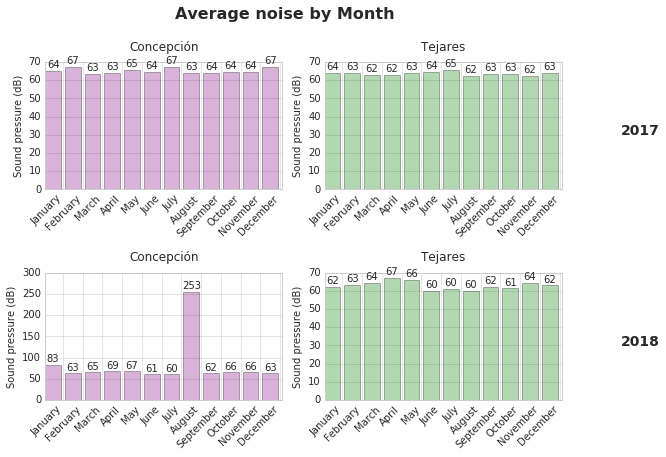

In [36]:
import calendar
import matplotlib.pyplot as plt
import numpy as np

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%d' % int(height),
                ha='center', va='bottom',fontsize=10)
        
sensores = df_noise_by_year_and_month.sensor_id.unique()
anios = df_noise_by_year_and_month.year.unique()
colors = {1: 'purple', 2:'green', 3:'blue'}
streets = {1: u'Concepción', 2: 'Tejares', 3: ''}

cnt=0
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 6))
    plt.suptitle('Average noise by Month', fontsize=16, y=1.05, fontweight='bold')
    for anio in anios:
        
        for sensor in sensores:
            cnt += 1
            ax = plt.subplot(len(sensores), len(anios), cnt)
            df_noise_tmp = df_noise_by_year_and_month.loc[(df_noise_by_year_and_month.year == anio) & (df_noise_by_year_and_month.sensor_id == sensor)]
            labels = list(map(lambda x: calendar.month_name[x], df_noise_tmp.month.values))
            values = df_noise_tmp['avg(noise)'].values
            rects = plt.bar(range(len(values)), values, alpha=0.3, color=colors[sensor])
            plt.title(streets[sensor],y=1.05)
            plt.ylabel('Sound pressure (dB)')
            plt.xticks(np.arange(0.9,len(values)), labels)
            plt.xticks(rotation=45,ha="right")
            autolabel(rects)
            if cnt % 2 == 0:
                plt.text(15, 30, anio, fontsize=14, fontweight='bold')
            
    plt.tight_layout()
    plt.show()